## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

# Contexte du projet

Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.
Le problème posé consiste à réutiliser un modèle de vision par ordinateur pré-entraîné (type CNN) pour l’adapter au contexte médical, sans repartir d’un entraînement complet.
Dans une logique de mise en production à moyen terme, il est également attendu de documenter et tracer les expérimentations réalisées. L’usage de MLflow est proposé pour initier cette démarche, en assurant le suivi des performances, la traçabilité des essais et la gestion des versions de modèles dans une perspective MLOps.

# 1. Importer les bibliothèques nécessaires
---

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import cv2
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)



# 2. Initialisation de MLflow
---

In [56]:
if not os.path.exists("mlruns"):
    os.makedirs('mlruns')
mlflow.set_tracking_uri(uri = "file:./mlruns")
mlflow.set_experiment("pneumonia_classification")

<Experiment: artifact_location='file:///Users/wassim/Desktop/Simplon/Brief/Brief_2/CNN-Transfer-Learning/mlruns/440693512193937605', creation_time=1747899191601, experiment_id='440693512193937605', last_update_time=1747899191601, lifecycle_stage='active', name='pneumonia_classification', tags={}>

# 3. Exploration des données
---

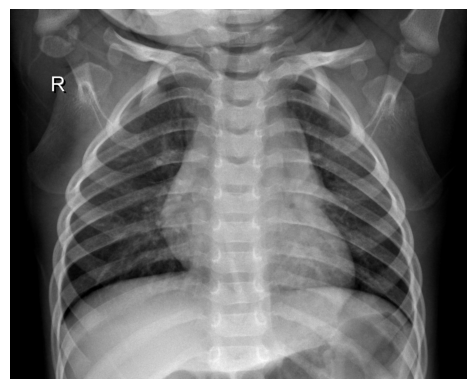

Shape (dimensions)    : (1152, 1422)
Type des valeurs      : uint8


In [57]:
# Chargement d'une image depuis un chemin local
img = cv2.imread("./data/chest_xray/train/NORMAL/IM-0117-0001.jpeg", cv2.IMREAD_GRAYSCALE)


# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image

print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

# 4. Chargement des données
---
Dans cette section, nous allons charger les données d'images à partir des répertoires fournis, en utilisant `ImageDataGenerator` de Keras pour la normalisation et l'augmentation des données. Nous allons également créer un générateur personnalisé pour équilibrer les classes en augmentant le nombre d'images de la classe "NORMAL" si nécessaire.

In [58]:
# chemin vers les dossiers contenant les images

train_dir = "./data/chest_xray/train"
test_dir = "./data/chest_xray/test"
val_dir = "./data/chest_xray/val"

# Paramétrés
target_size = (224, 224)
batch_size = 32
epochs = 10




# générateur d'images pour le jeu de validation et de test
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = ImageDataGenerator(
    rescale=1./255, # Normalisation des pixels entre 0 et 1
    rotation_range=15, # Rotation aléatoire des images
    zoom_range=0.1, # Zoom aléatoire
    width_shift_range=0.1, # Décalage horizontal aléatoire
    height_shift_range=0.1, # Décalage vertical aléatoire
    horizontal_flip=True # Miroir horizontal aléatoire
)


# On récupère l'index de la classe 'NORMAL'
normal_class_index = base_generator.class_indices['NORMAL']

# Custom generator dynamique
def count_images_in_class(directory, prefix=''):
    """Compte le nombre d'images dans un dossier avec un préfixe donné"""
    return len([f for f in os.listdir(directory) if f.endswith(('.jpeg', '.jpg', '.png')) and f.startswith(prefix)])

def balanced_generator(base_gen, target_augmented_count):
    """
    Générateur équilibré qui crée un nombre spécifique d'images augmentées
    seulement si nécessaire pour équilibrer les classes

    Parameters:
    -----------
    base_gen : ImageDataGenerator
        Le générateur de base
    target_augmented_count : int
        Nombre d'images augmentées à créer
    """
    normal_dir = os.path.join(train_dir, 'NORMAL')
    pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

    # Compter les images dans chaque classe
    normal_count = count_images_in_class(normal_dir)
    pneumonia_count = count_images_in_class(pneumonia_dir)
    augmented_count = count_images_in_class(normal_dir, 'augmented_normal_')

    print(f"Images NORMAL originales: {normal_count}")
    print(f"Images PNEUMONIA: {pneumonia_count}")
    print(f"Images augmentées existantes: {augmented_count}")

    # Vérifier si l'augmentation est nécessaire
    if normal_count >= pneumonia_count:
        print("Les classes sont déjà équilibrées ou la classe NORMAL est plus grande. Aucune augmentation nécessaire.")
        while True:
            x_batch, y_batch = next(base_gen)
            yield x_batch, y_batch
        return

    print(f"Images à générer: {target_augmented_count - augmented_count}")
    img_count = augmented_count

    while True:
        x_batch, y_batch = next(base_gen)
        x_augmented = np.zeros_like(x_batch)

        for i in range(len(x_batch)):
            if y_batch[i] == normal_class_index:
                if img_count >= target_augmented_count:
                    x_augmented[i] = x_batch[i]
                    continue

                # Appliquer l'augmentation
                x_augmented[i] = augment_datagen.random_transform(x_batch[i])

                # Sauvegarder l'image augmentée
                img_augmented = (x_augmented[i] * 255).astype(np.uint8)
                save_path = os.path.join(normal_dir, f'augmented_normal_{img_count:04d}.png')
                cv2.imwrite(save_path, cv2.cvtColor(img_augmented, cv2.COLOR_RGB2BGR))
                img_count += 1

                if img_count >= target_augmented_count:
                    print(f"\nGénération terminée : {target_augmented_count} images augmentées créées")
                    print(f"Total des images NORMAL : {normal_count + target_augmented_count}")
            else:
                x_augmented[i] = x_batch[i]

        yield x_augmented, y_batch


print("\nProcessus d'augmentation terminé !")
normal_dir = os.path.join(train_dir, 'NORMAL')
print(f"Images originales : {count_images_in_class(normal_dir) - count_images_in_class(normal_dir, 'augmented_normal_')}")
print(f"Images augmentées : {count_images_in_class(normal_dir, 'augmented_normal_')}")





Processus d'augmentation terminé !
Images originales : 1341
Images augmentées : 2534


In [59]:
# Creation des générateurs d'images

train_generator = train_generator.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)



Found 7750 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# 5. Création du modèle
---


### 5.1 Chargement du modèle pré-entraîné DenseNet121

In [60]:
def build_denseNet121_model(input_shape = (224,224,3)):
    base_model = DenseNet121(
        weights = "imagenet",
        include_top = False,
        input_shape = input_shape,
    )
    base_model.trainable = False  # On gèle les poids du modèle pré-entraîné
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Ajout d'une couche de pooling global
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs = base_model.input, outputs = x)
    return model


### 5.2 Fonction pour générer un nom de run unique

Nous allons créer une fonction pour générer un nom de run unique pour chaque exécution de modèle dans MLflow. Le nom du run sera basé sur le nom du modèle et le numéro d'exécution.

In [61]:
def get_next_run_name(model_name, experiment_name="pneumonia_classification"):
    '''
    Fonction pour générer un nom de run unique pour chaque exécution de modèle dans MLflow.
    Le nom du run est basé sur le nom du modèle et le numéro d'exécution.
    '''
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    run_names = runs["tags.mlflow.runName"] if "tags.mlflow.runName" in runs.columns else []
    if len(run_names) == 0:
        return f"{model_name} run 1"


    pattern = rf"{re.escape(model_name)} run (\d+)"
    existing_nums = [int(re.search(pattern, name).group(1))
                     for name in run_names if re.search(pattern, name)]

    next_run_number = max(existing_nums) + 1 if existing_nums else 1
    return f"{model_name} run {next_run_number}"

### 5.3 Connection au MLflow et entraînement au modèle DenseNet121


#### 5.3.1 Entraînement du model sans fine tuning

In [62]:
mlflow.end_run() # Pour s'assurer qu'il n'y a pas de run en cours
run_name_phase1 = get_next_run_name("DenseNet121_phase1")

with mlflow.start_run(run_name=run_name_phase1) as run1:
    mlflow.log_param("model_name", "DenseNet121")
    mlflow.log_param("phase", "frozen_layers")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    model_denseNet = build_denseNet121_model()
    model_denseNet.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history1 = model_denseNet.fit(
        train_generator,
        validation_data=val_generator,
        epochs = epochs,
    )
    
    model_path = "model_phase1.h5"
    model_denseNet.save(model_path)
    mlflow.log_artifact(model_path, artifact_path="model_phase1")

    mlflow.log_metric("val_accuracy", history1.history["val_accuracy"][-1])


/Users/wassim/Desktop/Simplon/Brief/Brief_2/CNN-Transfer-Learning/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 71s 255ms/step - accuracy: 0.8273 - loss: 0.3980 - val_accuracy: 0.8125 - val_loss: 0.3898
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 219ms/step - accuracy: 0.9239 - loss: 0.2115 - val_accuracy: 0.8125 - val_loss: 0.3920
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - accuracy: 0.9333 - loss: 0.1844 - val_accuracy: 0.8125 - val_loss: 0.3488
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - accuracy: 0.9380 - loss: 0.1734 - val_accuracy: 0.8125 - val_loss: 0.3205
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 227ms/step - accuracy: 0.9471 - loss: 0.1469 - val_accuracy: 0.8125 - val_loss: 0.3940
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 223ms/step - accuracy: 0.9463 - loss: 0.1471 - val_accuracy: 0.8125 - val_loss: 0.4233
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - accuracy: 0.9444 - loss: 0.1466 - val_accuracy: 0.7500 - val_loss: 0.3765
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - accuracy: 0.9494 - loss: 0

#### 5.3.2 Entraînement du model avec fine tuning

In [63]:
run_name_phase2 = get_next_run_name("DenseNet169_phase2")

with mlflow.start_run(run_name=run_name_phase2) as run2:
    mlflow.log_param("model_name", "DenseNet121")
    mlflow.log_param("phase", "fine_tuning")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    # Chargé le modèle de la phase 1
    model = tf.keras.models.load_model(model_path)

    # Décongeler les couches du modèle DenseNet121 pour le fine-tuning

    for layer in model.layers[-50:]:
        if not isinstance(layer, tf.keras.Model):
            layer.trainable = True

    # Recompiler le modèle avec un taux d'apprentissage plus faible
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Taux d'apprentissage réduit
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 10,
    )
    y_true = test_generator.classes
    y_pred_proba = model_denseNet.predict(test_generator, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype("int32").flatten()








Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 118s 391ms/step - accuracy: 0.9250 - loss: 0.1954 - val_accuracy: 0.8125 - val_loss: 0.4554
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 76s 306ms/step - accuracy: 0.9509 - loss: 0.1410 - val_accuracy: 0.8750 - val_loss: 0.3093
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 75s 307ms/step - accuracy: 0.9626 - loss: 0.1042 - val_accuracy: 0.8125 - val_loss: 0.3650
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 82s 334ms/step - accuracy: 0.9610 - loss: 0.1153 - val_accuracy: 0.9375 - val_loss: 0.2531
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 86s 354ms/step - accuracy: 0.9659 - loss: 0.0904 - val_accuracy: 0.9375 - val_loss: 0.2211
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 89s 364ms/step - accuracy: 0.9645 - loss: 0.0892 - val_accuracy: 0.9375 - val_loss: 0.1892
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 83s 341ms/step - accuracy: 0.9757 - loss: 0.0765 - val_accuracy: 0.8750 - val_loss: 0.2513
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1160s 5s/step - accuracy: 0.9737 - loss: 0

### 6. Évaluation du modèle
---

In [64]:
 # Evaluation

    # log des métriques dans MLflow
final_val_acc = history2.history["val_accuracy"][-1]
mlflow.log_metric("val_accuracy", final_val_acc)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)

mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("precision", precision)
mlflow.log_metric("recall", recall)
mlflow.log_metric("f1_score", f1)
mlflow.log_metric("roc_auc", auc)

    # Log du modèle final
mlflow.keras.log_model(model, "DenseNet121_finetuned")

# Courbe d'accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f"accuracy_curve {run_name_phase2}.png")  # Sauvegarde en local
mlflow.log_artifact(f"accuracy_curve {run_name_phase2}.png")  # Log dans MLflow
plt.close()

plt.figure()
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy Phase 1')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy Phase 2')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("Validation Accuracy entre les 2 phase.png")  # Sauvegarde en local
mlflow.log_artifact("Validation Accuracy entre les 2 phase.png")  # Log dans MLflow
plt.close()

# Courbe de loss
plt.figure()
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f"loss_curve {run_name_phase2}.png")
mlflow.log_artifact(f"loss_curve {run_name_phase2}.png")
plt.close()

plt.figure()
plt.plot(history1.history['val_loss'], label='Validation Loss Phase 1')
plt.plot(history2.history['val_loss'], label='Validation Loss Phase 2')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("Validation Loss entre les 2 phase.png")  # Sauvegarde en local
mlflow.log_artifact("Validation Loss entre les 2 phase.png")
plt.close()

# Matrice de confusion

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.savefig(f"Matrice de confusion {run_name_phase2}.png")  # Sauvegarde en local
mlflow.log_artifact(f"Matrice de confusion {run_name_phase2}.png")  # Log dans MLflow
plt.close()

2025/05/28 13:00:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/28 13:02:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### 7. Enregistrement du modèle final
---

In [67]:
model.save("models/final_model_densenet.keras")